## 1.Load Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [7]:
# Load data
df = pd.read_csv("data/Walmart.csv")
print(df.shape)
df.head()

(6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## 2. Data Understanding & Removing Outlier

In [9]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [11]:
# Cek missing value
print(df.isnull().sum())


Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [12]:
# Ringkasan statistik
df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6401.000000,6401,6.401000e+03,6401.000000,6401.000000,6401.000000,6401.000000,6401.000000
mean,23.054210,2011-06-17 04:24:33.519762432,1.036130e+06,0.068895,60.772042,3.359634,171.642219,8.002298
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.517431e+05,0.000000,47.660000,2.933000,131.784000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.572983e+05,0.000000,62.860000,3.452000,182.658578,7.874000
75%,34.000000,2012-02-24 00:00:00,1.414565e+06,0.000000,75.000000,3.737000,212.833640,8.622000
max,45.000000,2012-10-26 00:00:00,2.685352e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.991284,NaN,5.451961e+05,0.253296,18.417068,0.459696,39.359852,1.878705


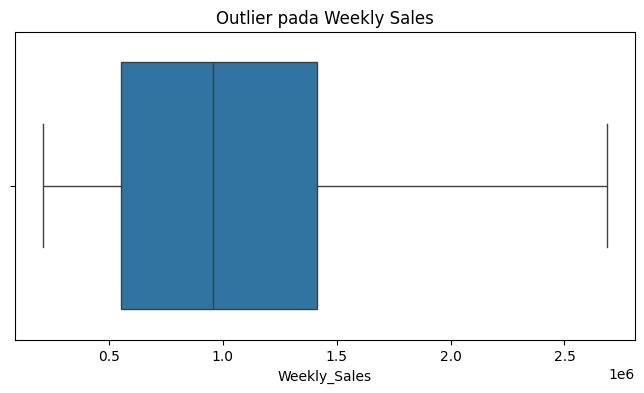

In [13]:
# Deteksi outlier pada Weekly_Sales
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Weekly_Sales'])
plt.title("Outlier pada Weekly Sales")
plt.show()

In [14]:
# Hilangkan outlier ekstrem (lebih dari Q3 + 1.5*IQR)
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df = df[df['Weekly_Sales'] <= upper_bound]

## 3. Univariate Analysis

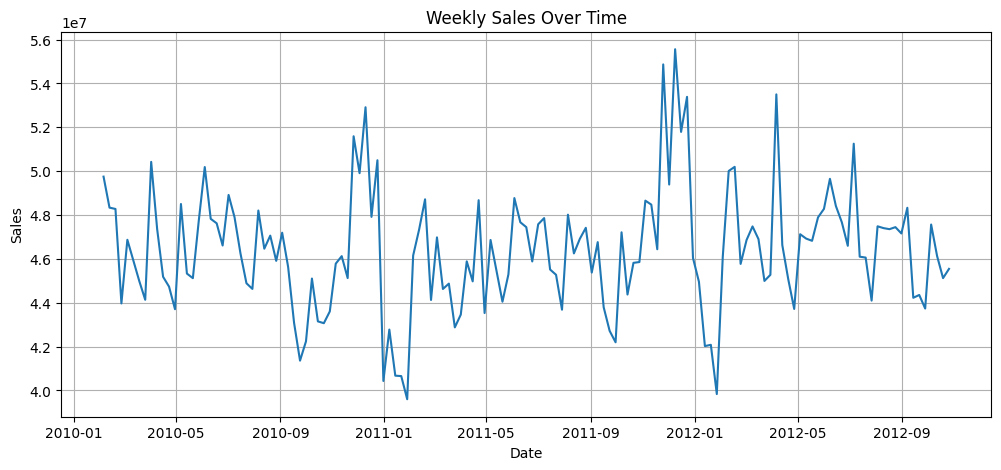

In [15]:
# Trend penjualan agregat
sales_by_date = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(sales_by_date['Date'], sales_by_date['Weekly_Sales'], label='Total Weekly Sales')
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


## 4. Multivariate Analysis

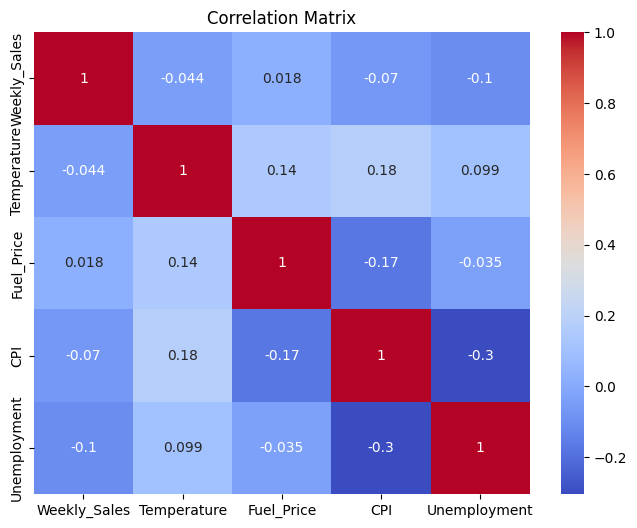

In [16]:
# Korelasi antara fitur numerik
numerics = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
corr = df[numerics].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## 5. Data Preparation

In [17]:
# Fokus pada total penjualan seluruh toko
sales_df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
sales_df.columns = ['ds', 'y']
sales_df = sales_df.sort_values('ds')

In [18]:
# Cek apakah data sudah terurut
sales_df.head()


,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


## 6. Modeling

### a. Prophet

15:26:00 - cmdstanpy - INFO - Chain [1] start processing
15:26:00 - cmdstanpy - INFO - Chain [1] done processing


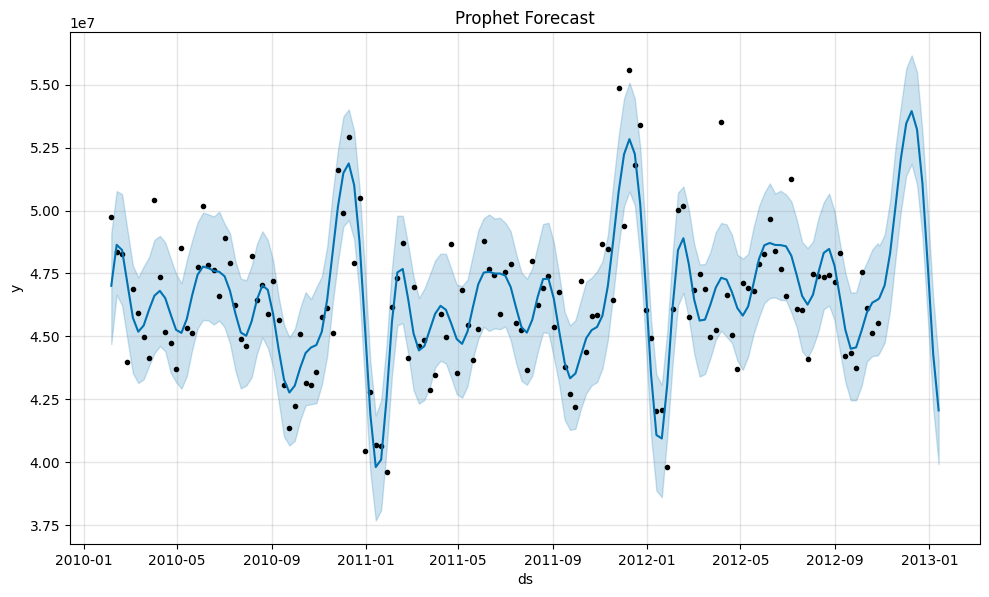

In [19]:
prophet_model = Prophet()
prophet_model.fit(sales_df)

# Forecast 12 minggu ke depan
future = prophet_model.make_future_dataframe(periods=12, freq='W')
forecast = prophet_model.predict(future)

# Plot hasil prediksi
prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()


### b.SARIMAX

c:\Users\ghani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\ghani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\ghani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


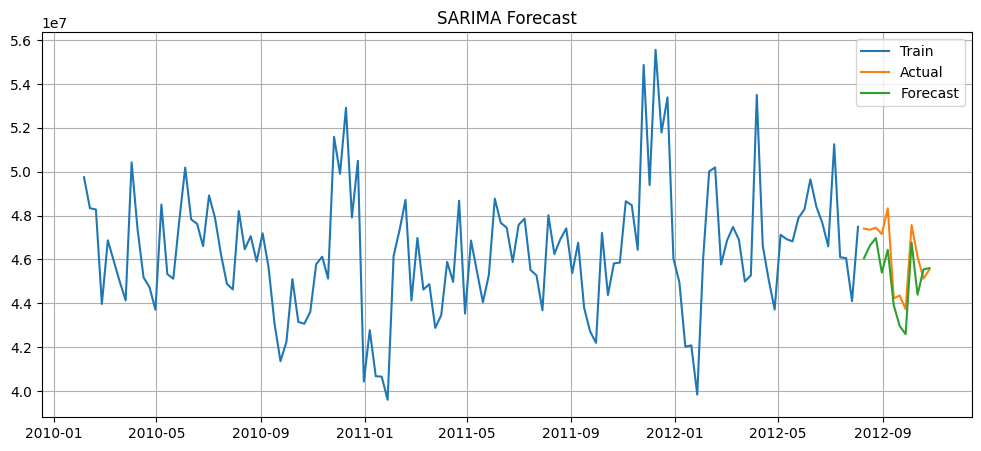

In [20]:
# Set index waktu
sarima_df = sales_df.copy()
sarima_df.set_index('ds', inplace=True)

# Split data: train dan test (12 minggu terakhir sebagai test)
train = sarima_df.iloc[:-12]
test = sarima_df.iloc[-12:]

# Fit SARIMAX (param bisa dituning)
sarima_model = SARIMAX(train['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_result = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_result.predict(start=test.index[0], end=test.index[-1])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['y'], label='Train')
plt.plot(test.index, test['y'], label='Actual')
plt.plot(test.index, sarima_forecast, label='Forecast')
plt.legend()
plt.title("SARIMA Forecast")
plt.grid(True)
plt.show()


## 7. Evaluation

In [21]:
# Prophet Evaluation
prophet_forecast = forecast.set_index('ds').loc[test.index]['yhat']
mae_prophet = mean_absolute_error(test['y'], prophet_forecast)
rmse_prophet = sqrt(mean_squared_error(test['y'], prophet_forecast))

# SARIMA Evaluation
mae_sarima = mean_absolute_error(test['y'], sarima_forecast)
rmse_sarima = sqrt(mean_squared_error(test['y'], sarima_forecast))

print("=== Model Evaluation ===")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")


=== Model Evaluation ===
Prophet MAE: 935680.16
Prophet RMSE: 1125847.00
SARIMA MAE: 1005444.31
SARIMA RMSE: 1170538.46
